simulating ER+ spine
Initial spine Ca =  0.05 uM
Initial ER Ca =  249.994 uM
1
0.00023534118588423565
simulating ER- spine
checkpoint


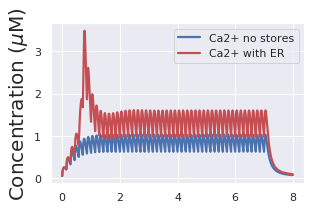

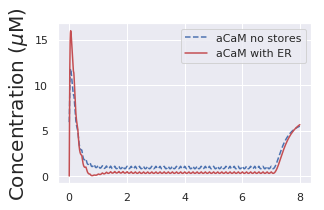

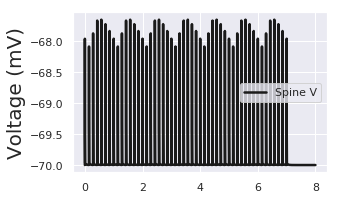

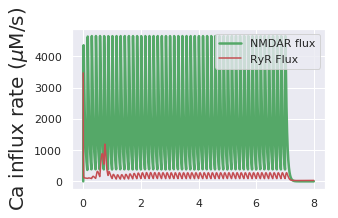

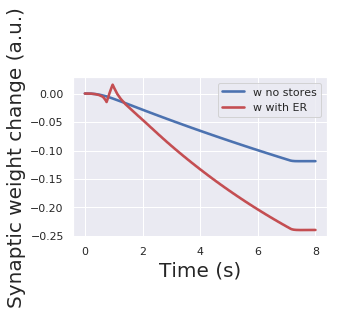

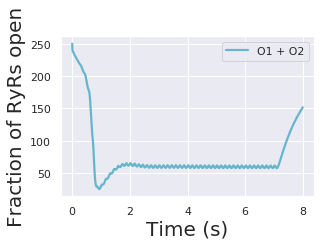

1.0 6.5e-11 0


In [16]:
# -*- coding: utf-8 -*-

# Created on Mon Dec  3 11:59:17 2018
# @author: Gaurang Mahajan, Vikrant Jaltare
# ##################################################################################################################################
# This program simulates calcium and plasticity dynamics in a physiologically plausible mathematical model of an ER-bearing CA1 
# dendritic spine head, as described in Mahajan & Nadkarni, bioRxiv 460568 (2018). The following python modules are imported: 
# numpy, scipy and matplotlib. The deterministic, coupled ODEs are numerically integrated using the "odeint" function in SciPy.
 
# The code prompts for the following inputs (inputs to be entered together in command line and separated by single spaces):
# gNMDAR:       NMDAR conductance parameter (pS),
# n_ip3r:       Number of IP3 receptors,
# input_type:   Either 'rdp' (presynaptic spikes only) or 'stdp' (paired pre and postsynaptic spiking),
# f_input:      Input frequency (Hz), 
# n_inputs:     Number of  inputs.
# n_RyR:        Number of RyR receptors
# If input_type is chosen as 'stdp', the user is prompted for two more inputs (to be entered together, separated by a space):
# n_bap:   Number of BAP (1 or 2) paired with every presynaptic spike (BAPs in a pair are separated by 10 ms),
# tdiff:   Spike timing difference between presynaptic spike and last postsynaptic BAP (in ms); pre-before-post is
#          associated with positive tdiff.
# Example usage: 
# >>>python code_for_spinemodel.py
# "Input gNMDAR (pS), no. of IP3R, input_type, input frequency (Hz), and no. of inputs: "
# 65 30 stdp 5 5
# "Input no. of BAP per input and spike timing difference (ms): "
# 2 10
# All other kinetic parameters and species concentrations are listed below, under the heading "Setting model parameters".
# All dynamical variables are initially set to arbitrary values, and the model is run for 500 sec (in the absence of inputs) 
# which ensures that all variables attain their steady-state resting levels. This state is taken as the initial condition 
# at the start of the simulations.
 
# The coupled ODEs are integrated first for the ER+ spine head, and then for the ER - spine head (which is equivalent to the 
# ER+ case, except that n_ip3r and Vmax_serca are set to 0).
# The model includes L-VGCC, which by default is ignored (g_vgcc set to 0) for the rdp input patterns.
# The parameter 'rho_spines' specifies the effective total strength of co-active synaptic inputs at the dendritic compartment 
# (mimicking SC inputs); it is set to zero by default. 
##################################################################################################################################


#!/usr/bin/env python

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#### Global constants:
rtol = 1e-6
atol = 1e-6 
F = 96485.33 ## Coulomb/mole
Nav = 6.022e23
e = 2.718
##############################################
#### Prompting the user for input parameters:
 
g_NMDAR,input_pattern,f_input,n_inputs,n_RyR = [65, 'rdp', 7, 50 ,30] #input("Input gNMDAR (pS), no. of IP3R, input_type, input frequency (Hz), no. of inputs, #RyRs: ").split(' ')
if input_pattern not in ['rdp','stdp']:
    print('input_type can only be "rdp" or "stdp"')
    raise SystemExit

if input_pattern == 'stdp': 
    n_bap, tdiff = [2, 10]#input("Input no. of BAP per input and spike timing difference (ms): ").split(' ')


##############################################################################################
#### Defining various functions used in model simulation:

##############################################################################################
#### Temporal profile of glutamate availability:

def glu(t,s):
    
    tau_glu = 1e-3 ## sec
    glu_0 = 2.718 * 300 ## uM
        
    if s == 0: 
        return 0
    if s == 1: 
        total = 0
        for tpuff in tpre:    
            if t > tpuff: total += glu_0 * np.exp(-(t-tpuff)/tau_glu) * ((t-tpuff)/tau_glu)
        return total
##############################################################################################

##############################################################################################
#### Voltage profile of BAP at the dendritic compartment:

def u_bpap(t):  ##Use this to get the voltage of the spine whenever required

    V0 = 67
    total = 0
    for tbp in tpost:
        if t > tbp: total += V0 * (0.7 * np.exp(-(t-tbp)/0.003) + 0.3 * np.exp(-(t-tbp)/0.04))
    return E_L + total
##############################################################################################
    
##############################################################################################    
#### AMPAR conductance profile: 

def I_A(s,u,t):

    if s==0:
        return 0
    else:
        total = 0
        for tpuff in tpre:
            if t>tpuff: total += g_A * (np.exp(-(t-tpuff)/tau_A2) - np.exp(-(t-tpuff)/tau_A1))  
        return total * (u - E_A)
##############################################################################################
        
##############################################################################################     
#### NMDAR conductance profile:

def I_N(s,u,t):

    if s==0:
        return 0
    if s==1:
        total = 0
        for tpuff in tpre:
            if t>tpuff: total += g_N * (np.exp(-(t-tpuff)/tau_N2) - np.exp(-(t-tpuff)/tau_N1))
        return total * (u - E_N) / (1 + 0.28 * np.exp(-0.062 * u))
##############################################################################################
        
##############################################################################################        
#### Plasticity model, Omega function

def wfun(x):

    U = -beta2*(x - alpha2)
    V = -beta1*(x - alpha1)
    if U>100: U = 100
    if V>100: V = 100        
    return (1.0/(1 + np.exp(U))) - 0.5*(1.0/(1 + np.exp(V)))
##############################################################################################
    
##############################################################################################    
#### Plasticity model, tau function

def wtau(x):

    return P1 + (P2/(P3 + (2*x/(alpha1+alpha2))**P4))
##############################################################################################
def theta(x):
    if(x > 0):
        return x
    else:
        return 0
#########################################################################################################################       
#### Coupled ODEs describing the ER-bearing spine head, which is resistively coupled to a dendritic compartement via a passive neck:       

def spine_model(x,t):
    
    
    pH, pL, cbp, Bslow, calb, calb_m1, calb_h1, calb_m2, calb_h2, calb_m1h1, calb_m2h1, calb_m1h2, c1n0, c2n0, c0n1, c0n2, c1n1, c2n1, c1n2, c2n2, mv, hv, w, u, ud,\
    ca_er, ca, R, c1, c2, c3, c4, c5, o1, o2 = x
    ###########|----------- RyR --------| ##############

    nt = glu(t,s)

    if (s>0 and input_pattern=='stdp'): 
        ud = u_bpap(t)
        
    
    
    ca_eq = 0.01 


    
    ## RyR Kinetics:#################################################
    Jrel = gRyR * Vr * (o1 + o2) * (ca_er - ca) 
    ######################### Channel Ca Release ########################################
    ca_eq += n_RyR * Jrel  #+ ip3r_tot * ((x*y*h)**3) * alpha_ip3r * (ca_er - ca)/(Nav * Vspine)   ## Ca released from RyR also contributes to the cytosolic Ca
    ca_er_eq = - n_RyR * Jrel  +  (ca_er_0 - ca_er)/(tau_refill)#-alpha_ip3r * ip3r_tot * ((x*y*h)**3) * (ca_er - ca)/(Nav * Ver)   ## Additional Ca depletion due to RyR
########################################################################################################################
    
    ## Buffer equations:

    Bslow_eq = -kslow_f*Bslow*ca + kslow_b*(Bslow_tot - Bslow)
    ca_eq += -kslow_f*Bslow*ca + kslow_b*(Bslow_tot - Bslow)
    
    cbp_eq = -kbuff_f*ca*cbp + kbuff_b*(cbp_tot - cbp)
    ca_eq += -kbuff_f*ca*cbp + kbuff_b*(cbp_tot - cbp)    
    
    calb_m2h2 = calb_tot - calb - calb_m1 - calb_h1 - calb_m2 - calb_h2 - calb_m1h1 - calb_m2h1 - calb_m1h2
    calb_eqs = [ -ca*calb*(km0m1 + kh0h1) + km1m0*calb_m1 + kh1h0*calb_h1,\
                     ca*calb*km0m1 - km1m0*calb_m1 + calb_m2*km2m1 - ca*calb_m1*km1m2 + calb_m1h1*kh1h0 - ca*calb_m1*kh0h1,\
                     ca*calb*kh0h1 - kh1h0*calb_h1 + calb_h2*kh2h1 - ca*calb_h1*kh1h2 + calb_m1h1*km1m0 - ca*calb_h1*km0m1,\
                     ca*calb_m1*km1m2 - km2m1*calb_m2 + kh1h0*calb_m2h1 - ca*kh0h1*calb_m2,\
                     ca*calb_h1*kh1h2 - kh2h1*calb_h2 + km1m0*calb_m1h2 - ca*km0m1*calb_h2,\
                     ca*(calb_h1*km0m1 + calb_m1*kh0h1) - (km1m0+kh1h0)*calb_m1h1 - ca*calb_m1h1*(km1m2+kh1h2) + kh2h1*calb_m1h2 + km2m1*calb_m2h1,\
                     ca*km1m2*calb_m1h1 - km2m1*calb_m2h1 + kh2h1*calb_m2h2 - kh1h2*ca*calb_m2h1 + kh0h1*ca*calb_m2 - kh1h0*calb_m2h1,\
                     ca*kh1h2*calb_m1h1 - kh2h1*calb_m1h2 + km2m1*calb_m2h2 - km1m2*ca*calb_m1h2 + km0m1*ca*calb_h2 - km1m0*calb_m1h2 ]
    ca_eq += -ca*(km0m1*(calb+calb_h1+calb_h2) + kh0h1*(calb+calb_m1+calb_m2) + km1m2*(calb_m1+calb_m1h1+calb_m1h2) + kh1h2*(calb_h1+calb_m1h1+calb_m2h1))+\
                km1m0*(calb_m1+calb_m1h1+calb_m1h2) + kh1h0*(calb_h1+calb_m1h1+calb_m2h1) + km2m1*(calb_m2+calb_m2h1+calb_m2h2) + kh2h1*(calb_h2+calb_m1h2+calb_m2h2)
  
    ## Ca2+/calmodulin kinetics:
    
    c0n0 = cam_tot - c1n0 - c2n0 - c0n1 - c0n2 - c1n1 - c2n1 - c1n2 - c2n2
    c1n0_eq = -(k2c_on*ca + k1c_off + k1n_on*ca)*c1n0 + k1c_on*ca*c0n0 + k2c_off*c2n0 + k1n_off*c1n1
    c2n0_eq = -(k2c_off + k1n_on*ca)*c2n0 + k2c_on*ca*c1n0 + k1n_off*c2n1
    c0n1_eq = -(k2n_on*ca + k1n_off + k1c_on*ca)*c0n1 + k1n_on*ca*c0n0 + k2n_off*c0n2 + k1c_off*c1n1
    c0n2_eq = -(k2n_off + k1c_on*ca)*c0n2 + k2n_on*ca*c0n1 + k1c_off*c1n2
    c1n1_eq = -(k2c_on*ca + k1c_off + k1n_off + k2n_on*ca)*c1n1 + k1c_on*ca*c0n1 + k1n_on*ca*c1n0 + k2c_off*c2n1 + k2n_off*c1n2
    c2n1_eq = -(k2c_off + k2n_on*ca)*c2n1 + k2c_on*ca*c1n1 + k2n_off*c2n2 + k1n_on*ca*c2n0 - k1n_off*c2n1
    c1n2_eq = -(k2n_off + k2c_on*ca)*c1n2 + k2n_on*ca*c1n1 + k2c_off*c2n2 + k1c_on*ca*c0n2 - k1c_off*c1n2
    c2n2_eq = -(k2c_off + k2n_off)*c2n2 + k2c_on*ca*c1n2 + k2n_on*ca*c2n1
    cam_eqs = [c1n0_eq, c2n0_eq, c0n1_eq, c0n2_eq, c1n1_eq, c2n1_eq, c1n2_eq, c2n2_eq]
    ca_eq += -ca*(k1c_on*(c0n0+c0n1+c0n2) + k1n_on*(c0n0+c1n0+c2n0) + k2c_on*(c1n0+c1n1+c1n2) + k2n_on*(c0n1+c1n1+c2n1)) + \
    k1c_off*(c1n0+c1n1+c1n2) + k1n_off*(c0n1+c1n1+c2n1) + k2c_off*(c2n0+c2n1+c2n2) + k2n_off*(c0n2+c1n2+c2n2)
 
    ## PMCA/NCX kinetics:
    
    ca_eq += pH*kH_leak - ca*pH*k1H + k2H*(pHtot - pH)  +  pL*kL_leak - ca*pL*k1L + k2L*(pLtot - pL)
    pH_eq = k3H*(pHtot - pH) - ca*pH*k1H + k2H*(pHtot - pH)
    pL_eq = k3L*(pLtot - pL) - ca*pL*k1L + k2L*(pLtot - pL)
    
    
    ## SERCA kinetics:

    ca_eq += -Vmax_serca * ca**2/(Kd_serca**2 + ca**2) + k_erleak*(ca_er - ca)

    ## VGCC equatiosn:

    mv_eq = ((1.0/(1 + np.exp(-(u-um)/kmv))) - mv)/tau_mv
    hv_eq = ((1.0/(1 + np.exp(-(u-uh)/khv))) - hv)/tau_hv
    I_vgcc = -0.001 * Nav * 3.2e-19 * g_vgcc * (mv**2) * hv * 0.078 * u * (ca - ca_ext*np.exp(-0.078*u))/(1 - np.exp(-0.078*u))
    
    ## Spine and dendrite voltage eqns:
  

    sp_hh_eq = -(1/Cmem) * ( g_L*(u - E_L) + I_A(s,u,t)/Aspine + I_N(s,u,t)/Aspine - (gc/Aspine)*(ud - u) - I_vgcc/Aspine)
    dend_hh_eq = -(1/Cmem) * ( g_L*(ud - E_L) + rho_spines*gc*(ud - u))

    ## Ca2+ influx through NMDAR and VGCC:
    #print(g_N, n_RyR)
    ca_eq += -(g_N_Ca/Vspine) * (I_N(s,u,t)/(g_N*(u - E_N))) * 0.078 * u * (ca - ca_ext*np.exp(-0.078*u))/(1 - np.exp(-0.078*u)) \
            -(g_vgcc/Vspine) * (mv**2) * hv * 0.078 * u * (ca - ca_ext*np.exp(-0.078*u))/(1 - np.exp(-0.078*u))   
    
    ################################## RyR Dynamics #################################################
    dRdt  = -R*ca*kRc1 + c1*kc1R
    dc1dt = -(kc1c2*ca+ kc1R)*c1 + c2*kc2c1 + kRc1*ca*R
    dc2dt = -(kc2c3*ca + kc2c1)*c2 + kc3c2*c3 + kc1c2*ca*c1
    dc3dt = -(kc3c4*ca + kc3c2)*c3 + kc2c3*ca*c2 + kc4c3*c4
    dc4dt = -(kc4o1 + kc4o2 + kc4c3)*c4 + kc3c4*ca*c3 + ko1c4*o1 + ko2c4*o2
    dc5dt = -(kc5o1 + kc5o2 + kc5I)*c5 + ko1c5*o1 + kIc5*(1-R-c1-c2-c3-c4-c5-o1-o2) + ko2c5*o2
    do1dt = -(ko1c5 + ko1c4)*o1 + kc4o1*c4 + kc5o1*c5
    do2dt = -(ko2c4 + ko2c5)*o2 + kc4o2*c4 + kc5o2*c5
    ##################################################################################################
    ## Equation for plasticity variable w:
    acam = cam_tot - c0n0    
    w_eq = (1.0/wtau(acam))*(wfun(acam) - w)
    
    

    return [pH_eq, pL_eq, cbp_eq, Bslow_eq] + calb_eqs + cam_eqs + [mv_eq, hv_eq] + [w_eq] + [sp_hh_eq, dend_hh_eq,\
            ca_er_eq, ca_eq] + [dRdt, dc1dt, dc2dt, dc3dt, dc4dt, dc5dt, do1dt, do2dt]
##############################################################################################################################################################


##############################################
#### Setting model parameters:
##############################################
## Spine compartment and ER size:
Vspine = 0.06 ## um^3
d_spine = (6*Vspine/3.14)**0.333  ## um
Aspine = 3.14 * d_spine**2 * 1e-8  ## cm^2
Vspine = Vspine * 1e-15 ## liter
Aer = 0.1 * Aspine  ## cm^2
Ver = 0.1 * Vspine  ## liter
Vspine = Vspine-Ver  ## liter

 


## Parameters for endogenous immobile buffer (CBP): 
kbuff_f = 247 ## /uM/s
kbuff_b = 524 ## /s

## Parameters for endogenous slow buffer:
kslow_f = 24.7 ## /uM/s
kslow_b = 52.4 ## /s

## Parameters for calbindin-Ca2+ kinetics:
km0m1=174 ## /uM/s
km1m2=87 ## /uM/s
km1m0=35.8 ## /s
km2m1=71.6 ## /s
kh0h1=22 ## /uM/s
kh1h2=11 ## /uM/s
kh1h0=2.6 ## /s
kh2h1=5.2 ## /s

## Parameters for PMCA and NCX pumps:
k1H,k2H,k3H,kH_leak = [150,15,12,3.33]  ## (/uM/s, /s, /s, /s)
k1L,k2L,k3L,kL_leak = [300,300,600,10]  ## (/uM/s, /s, /s, /s)

## Parameters for CaM-Ca2+ interaction:
k1c_on = 6.8  ## /uM/s
k1c_off = 68  ## /s
k2c_on = 6.8 ## /uM/s
k2c_off = 10 ## /s
k1n_on = 108 ## /uM/s
k1n_off = 4150 ## /s
k2n_on = 108 ## /uM/s
k2n_off = 800 ## /s

## Membrane and leak parameters:
Cmem = 1e-6 ##  F/cm^2
g_L = 2e-4  ## S/cm^2
E_L = -70   ## mV

## AMPA receptor parameters:
tau_A1 = 0.2e-3 ## s
tau_A2 = 2e-3  ## s
E_A = 0  ## mV
g_A = 0.5e-9  ## S

## NMDA receptor parameters:
tau_N1 = 5e-3 ## s
tau_N2 = 50e-3 ## s
E_N = 0  ## mV
g_N = float(g_NMDAR) * 1e-12  ## S

## L-VGCC parameters:
um = -20 ## mV
kmv = 5  ## mV
tau_mv = 0.08e-3 ## sec
uh = -65  ## mV
khv = -7 ## mV			 
tau_hv = 300e-3  ## sec

## Spine neck parameters:
Rneck = 1e8  ## Ohm
gc = 1.0/Rneck ## S
rho_spines = 0  ## Surface density of co-active synaptic inputs on dendritic compartment (cm^-2)

## SERCA kinetic parameters:
Vmax_serca = 1  ## uM/sec
Kd_serca = 0.2 ## uM

## Parameters for Ca2+-based plasticity model:
P1,P2,P3,P4 = [1.0,10.0,0.001,2]
beta1,beta2 = [60,60]  ## /uM
alpha1,alpha2 = [2.0,20.0] ## uM

## ER refilling timescale:
tau_refill = 1e0  ## sec

####################### Ryanodine Receptor Model ############################
###################### Based on paper by Dura et al. (2002) #################
##### The model consists of a gating scheme consisting of 5 closed states and 2 open states ####

#################### Rate Constants ###################################
kon = 712.0 #1/(uM.s)
koff = 3000.0 #### units of all the quantities hereafter is s^-1 ######
kc4o1 = 10000.0 
kc4o2 = 1
ko1c4 = 500
ko2c4 = 0.5
ko1c5 = 2.0
ko2c5 = 3000.0
kc5o1 = 0.6666
kc5o2 = 100.0
kc5I  = 0.5
kIc5 = 1.5
kRc1 = 4*kon
kc1R = koff
kc1c2 = 3*kon
kc2c1 = 2*koff
kc2c3 = 2*kon
kc3c2 = 3*koff
kc3c4 = kon
kc4c3 = 4*koff


#########################################################
########### Concentrations of various species ###########
#########################################################

## External Ca (uM):
ca_ext = 2e3

## Resting cytosolic Ca (uM):ip3
ca_0 = 0.05

## Resting Ca in ER (uM):
ca_er_0 = 250 #100 

## Total calbindin concentration in spine (uM):
calb_tot = 45

## Total CBP concentration in the spine (uM):
cbp_tot = 80

## Total slow buffer concentration in the spine (uM):
Bslow_tot = 40

## Total concentration of PMCA and NCX pumps in the spine head (uM):
pHtot = (1e14) * 1000 * Aspine/(Nav * Vspine)
pLtot = (1e14) * 140 * Aspine/(Nav * Vspine)

## Total concentration of CaM in spine (uM):
cam_tot = 50


#########################################################################################



###########################################################################################################
#### Start of simulations
#########################################################

################ RyR ########################################
#### The model consists of a gating scheme consisting of 5 closed states and 2 open states ####
#################### Rate Constants ###################################
kon = 712.0 #1/(uM.s)
koff = 3000.0 #### units of all the quantities hereafter is s^-1 ######
kc4o1 = 10000.0 
kc4o2 = 1
ko1c4 = 500
ko2c4 = 0.5
ko1c5 = 2.0
ko2c5 = 3000.0
kc5o1 = 0.6666
kc5o2 = 100.0
kc5I  = 0.5
kIc5 = 1.5
kRc1 = 4*kon
kc1R = koff
kc1c2 = 3*kon
kc2c1 = 2*koff
kc2c3 = 2*kon
kc3c2 = 3*koff
kc3c4 = kon
kc4c3 = 4*koff
##########################################################
######## RyR parameters (play around these to make sure everyting works well together) ##########
gRyR = 10 #s^-1  ## Johenning's data -> see analysis
Vr = 0.185 #volume ratio of RyR to spine


##########################################################################################################
######################## Initializing all variables:######################################################
########################################################################################################

#mGluR_init = [0,0,0,0,0,0.8,0,0,0,0,0,0,0,0.3,0,0,0,1.0,ip5pconc,0,0,0,ip3kconc]
pumps_init = [pHtot, pLtot]
buff_init =  [cbp_tot, Bslow_tot] + [calb_tot,0,0,0,0,0,0,0] 
CaM_init = [0]*8  
vgcc_init = [0,1] 
w_init = [0] 
voltage_init = [E_L, E_L]
#ip3r_init = [1]
ca_init = [ca_er_0, ca_0]
RyR_init = [1/8]*8
     
xinit0 = pumps_init + buff_init + CaM_init + vgcc_init + w_init + voltage_init + ca_init + RyR_init
#print(len(xinit0), len(RyR_init))
g_N_Ca = 0.1 * (g_N/(2*F*78.0*ca_ext)) * 1e6   ## Ca conductance of NMDAR channels; liter/sec
if input_pattern == 'rdp': g_vgcc = 0  ## VGCC ignored for presynaptic-only inputs
else: g_vgcc = g_N_Ca
k_erleak = Vmax_serca * (ca_0**2)/((Kd_serca**2 + ca_0**2)*(ca_er_0 - ca_0))  ## /s

###################################################################################################################
 
########################################################################################################
#### Running the ER+ spine model in the absence of inputs to converge to steady state (resting state): 
########################################################################################################
  
s = 0      
print('simulating ER+ spine')
t0 = np.arange(0,1000,0.001)
#print(spine_model(xinit0, 0))
sol = odeint(spine_model,xinit0,t0,atol=atol,rtol=rtol)
#print(np.shape(sol))
print('Initial spine Ca = ', round(sol[-1,-9],3),'uM')
print('Initial ER Ca = ', round(sol[-1,-10],3),'uM')
#print('Initial spine IP3 = ', round(sol[-1,2],3),'uM')

########################################################################################################

###################################################################################
#### Integrating the ER+ spine model in the presence of user-defined input pattern:
###################################################################################

s = 1

tpre = [i/float(f_input) for i in range(int(float(n_inputs)))]

if input_pattern == 'stdp':
    tdiff = 0.001*float(tdiff)
    n_bap = int(float(n_bap))
    if n_bap == 1: 
        tpost = [i + tdiff for i in tpre]
    if n_bap == 2: 
        tpost = [i + tdiff for i in tpre] + [i + tdiff - 0.01 for i in tpre]
        t = np.arange(np.min(tpre+tpost),np.max(tpre+tpost), 1e-4)   ### Trying to reduce the resolution to get a faster speed
    #t = np.linspace(np.min(tpre+tpost),np.max(tpre+tpost)+1.,10000)
    
    
else: 
    t = np.arange(np.min(tpre),np.max(tpre)+1.,1e-3)
    #t = np.linspace(np.min(tpre),(np.max(tpre)+1.)*2,10000)

xinit = xinit0#sol[-1,:]
sol = odeint(spine_model,xinit,t,atol=atol,rtol=rtol)
#print('Blew up at user defined input for ER+ if it comes before this')
#open_prob = [((ip3/(ip3+d1))*(ca/(ca + d5))*h)**3 for ip3,ca,h in zip(sol[:,2],sol[:,-9],sol[:,-11])]
##print('divide by zero is at open_prob')
nmdar_flux = [-(g_N_Ca/Vspine) * (I_N(s,u,i)/(g_N*(u - E_N))) * 0.078 * u * (ca - ca_ext*np.exp(-0.078*u))/(1 - np.exp(-0.078*u)) for i,u,ca in zip(t,sol[:,-1],sol[:,-9])]
##print('divide by zero at nmdar_flux')
#ip3r_flux = [alpha_ip3r * ip3r_tot * op * (ca_er - ca)/(Nav * Vspine) for op,ca_er,ca in zip(open_prob,sol[:,-10],sol[:,-9])]
####### RyR Flux ########
JRyR = [(gRyR * n_RyR * Vr * (o1 + o2) * (ca_er - ca))  for o1,o2,ca_er,ca in zip(sol[:,-1], sol[:,-2], sol[:,-10], sol[:,-9])]
print(Vmax_serca)
print(k_erleak)
############################################################################################################################################################################

#######################################################################################################
#### Simulating the ER- spine model responding to the same input pattern as above:
#######################################################################################################
print('simulating ER- spine')
#ip3r_tot = 0
Vmax_serca = 0
k_erleak = 0
n_RyR = 0

s = 0
sol0 = odeint(spine_model,xinit0,t0,atol=atol,rtol=rtol)
###print('Blew up at user defined input for ER- if it comes before this')
###print(sol0)

s = 1
xinit = sol0[-1,:]
sol0 = odeint(spine_model,xinit,t,atol=atol,rtol=rtol)
print('checkpoint')

########################################################################################################

####################################################################################################
#### Plotting time course of various quantities:
####################################################################################################
sns.set()
plt.figure(figsize = (10,10))
plt.subplot(3,2,1)
plt.plot(t,sol0[:,-9],'b-',label='Ca2+ no stores',linewidth=2.2)
plt.plot(t,sol[:,-9],'r-',label='Ca2+ with ER',linewidth=2.2)
plt.legend(loc='best')
plt.ylabel('Concentration ($\mu$M)',size=20)

plt.figure(figsize = (10,10))
plt.subplot(3,2,3)
plt.plot(t,[np.sum(sol0[k,5]) for k in range(len(t))],'b--',label='aCaM no stores') #34:42
plt.plot(t,[np.sum(sol[k,5]) for k in range(len(t))],'r-',label='aCaM with ER') #linewidth
plt.legend(loc='best')
plt.ylabel('Concentration ($\mu$M)',size=20)

plt.figure(figsize = (10,10))
plt.subplot(3,2,2)
plt.plot(t,sol[:,-12],'k-',label='Spine V',linewidth=2.5)
plt.legend(loc='best')
plt.ylabel('Voltage (mV)',size=20)

plt.figure(figsize = (10,10))
plt.subplot(3,2,4)
plt.plot(t,nmdar_flux,'g-',linewidth=2.5,label='NMDAR flux')
#plt.plot(t,ip3r_flux,'m-',linewidth=2.5,label='IP3R flux')
plt.plot(t, JRyR, 'r-', label='RyR Flux')
plt.legend(loc='best')
plt.ylabel('Ca influx rate ($\mu$M/s)',size=20)

plt.figure(figsize = (10,10))
plt.subplot(3,2,5)
plt.plot(t,sol0[:,-13],'b-',label='w no stores',linewidth=2.6)
plt.plot(t,sol[:,-13],'r-',label='w with ER',linewidth=2.6)
plt.legend(loc='best')
plt.ylabel('Synaptic weight change (a.u.)',size=20)
plt.xlabel('Time (s)',size=20)

plt.figure(figsize = (10,10))
plt.subplot(3,2,6)
plt.plot(t,sol[:,-10],'c-',label='O1 + O2',linewidth=2.2)
plt.legend(loc='best')
#plt.xlabel('Time (s)',size=21)
plt.ylabel('Fraction of RyRs open',size=20)
plt.xlabel('Time (s)',size=20)
plt.show()            
################################################################################################## 
#print(sol[:,-13])
print(tau_refill, g_N, n_RyR)

In [ ]:
################# variation of steady state Ca with RyRs and nmda conductance #######
tau_refill = 1e-1
ryrTr = np.arange(50.,70.,2)
gnmdaTr = np.arange(20.,180, 20)

print(gnmdaTr.shape[0], ryrTr.shape[0])
gnmda = np.zeros((gnmdaTr.shape[0], ryrTr.shape[0]))
ryrArr = np.zeros((gnmdaTr.shape[0], ryrTr.shape[0]))

for count in range(ryrTr.shape[0]):
    gnmda[:, count] = gnmdaTr

for count in range(gnmdaTr.shape[0]):
    ryrArr[count,:] = ryrTr

gnmda = gnmda.reshape((gnmdaTr.shape[0] * ryrTr.shape[0], 1))
ryrArr = ryrArr.reshape((gnmdaTr.shape[0] * ryrTr.shape[0], 1))

#################################################################
itr = 0
################ solving ##############################
caTr = np.zeros((gnmdaTr.shape[0], ryrTr.shape[0]))  ## 170x50 array
xinit = sol[-1,:]
t3 = np.arange(0.,4.,0.01)

for nmda in range(gnmdaTr.shape[0]):
    for RyR in range(ryrTr.shape[0]):
        g_NMDAR, n_RyR, n_inputs, input_pattern, f_input  = [gnmdaTr[nmda], ryrTr[RyR], 1, 'rdp', 5]  #g_NMDAR is in pS
        g_N = float(g_NMDAR) * 1e-12   ##missing step
        s = 1 
        sol3 = odeint(spine_model, xinit0, t)
        caTr[nmda,RyR] =sol3[-1,-9]#max(sol3[:,-9])
        itr+=1
        print(itr,g_N,n_RyR,caTr[nmda,RyR], tau_refill)
        

In [ ]:
########### saving in a csv ###############
caTr0 = caTr.reshape((gnmdaTr.shape[0] * ryrTr.shape[0], 1))
heatmapArray = np.concatenate((np.flip(gnmda),ryrArr,caTr0),axis=1)
heatmapArray.shape
np.savetxt('grc5_1.csv', heatmapArray, delimiter =',', fmt = ['%f','%f','%f'], header = 'gNMDAR,RyR,Ca', comments='')
 ##grcn_x => conductance, ryr, calcium for 10^-x tau_refill, the n stands for number of inputs


In [ ]:
hmap = pd.read_csv('grc5_&01.csv')
plt.title('tau_refill=0.1s')
hmap = hmap.pivot('RyR','gNMDAR','Ca')
ax = sns.heatmap(hmap)


In [ ]:
for i in range(ryrTr.shape[0]):
    plt.figure(figsize = (8,8))
    plt.subplot(7,2,i+1)
    plt.plot(gnmdaTr, caTr[:,i])


array([0.05      , 0.13219584, 0.13480086, ..., 0.07967258, 0.07967081,
       0.07966905])

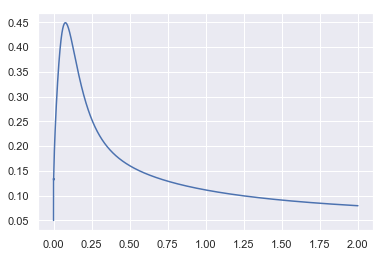

In [156]:
tau_refill = 1e-2
g_NMDAR, n_RyR, n_inputs, input_pattern  = 500., 40., 1, 'rdp'
s = 1 
g_N = float(g_NMDAR) * 1e-12 
sol3 = odeint(spine_model, xinit0, t)
plt.plot(t,sol3[:,-9])
sol3[:,-9]


In [158]:
a = np.arange(0,10)
print(a)
a = np.flip(a)
print(a)

[0 1 2 3 4 5 6 7 8 9]
[9 8 7 6 5 4 3 2 1 0]


# Rate Dependent Plasticity Protocol:
 * Capturing the Calcium - CaM time course for an input of 50 pulses (without cluster) by varying the input frequency from 0.1Hz to 20Hz (in steps of 0.1Hz)
 * Plotting the steady state Ca<sup>2+</sup> as a function of induction frequency
 
### Details:
 - n$_{RyR}$ = 30
 - g$_{NMDAR}$ = 65pS
 - $\tau_{refill}$ = 1s (at the beginning, can be changed to 0.1s)
 - File name: rdpn_t_r_x.csv, where n = number of input pulses, x = 1 for ER+ spine and 0 for ER- spine, t = $\tau_{refill}$ , r = #RyRs, r won't be there for no ER spine
 

In [ ]:
################################ Rate Dependent Plasticity Protocol ###########################
tau_refill = 1e-1 #s
fTrace = np.arange(0.1, 20.1, 0.5e0)
t4 = np.arange(0., 260., 1e-3)
CaTimeCourse = np.zeros((t4.shape[0], fTrace.shape[0]))  ## With ER Stores (RyR mediated)
CaTimeCourse0 = np.zeros((t4.shape[0], fTrace.shape[0])) ## Without ER stores (not mediated by RyR)
itr = 0
for freq in range(fTrace.shape[0]):
    g_NMDAR, n_RyR, n_inputs, input_pattern, f_input  = [65, 30, 25, 'rdp', fTrace[freq]]  #g_NMDAR is in pS
    g_N = float(g_NMDAR) * 1e-12 
    s = 1
    xinit = sol[-1,:]
    print('RyRs to ER+ spine = ', n_RyR)
    tpre = [i/float(f_input) for i in range(int(float(n_inputs)))]
    print('simulating ER+ spine')
    sol4 = odeint(spine_model, xinit, t4, atol=atol,rtol=rtol )   ## with ER stores
    ##############################################################
    Vmax_serca = 0
    k_erleak = 0
    n_RyR = 0
    print('simulating ER- spine')
    sol40 = odeint(spine_model, xinit, t4, atol=atol,rtol=rtol)  ##without ER stores
    CaTimeCourse[:,freq] = sol4[:,-9]
    CaTimeCourse0[:,freq] = sol40[:,-9]

    itr += 1
    print(itr)
    
print('done')

In [83]:
################################## Saving into csv file ####################################
np.savetxt('rdp25_1_0.csv', CaTimeCourse0 , delimiter =',', fmt = ['%f']*fTrace.shape[0], header = '', comments='')
np.savetxt('rdp25_1_10_1.csv', CaTimeCourse , delimiter =',', fmt = ['%f']*fTrace.shape[0], header = '', comments='')

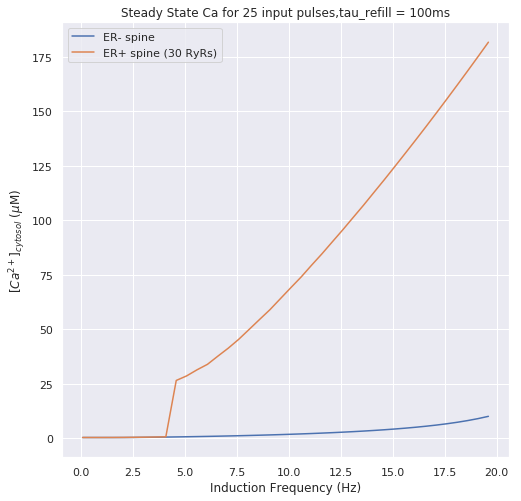

In [84]:
################################ Plotting ##################################
CaTime0 = pd.read_csv('rdp25_1_0.csv')
CaTime1 = pd.read_csv('rdp25_1_30_1.csv')
CaTime0 = np.array(CaTime0)
CaTime1 = np.array(CaTime1)

ca0 = [np.max(CaTime0[:,i]) for i in range(fTrace.shape[0])]
ca1 = [np.max(CaTime1[:,i]) for i in range(fTrace.shape[0])]

plt.figure(figsize = (8,8))
plt.title('Steady State Ca for 25 input pulses,tau_refill = 100ms')
plt.plot(fTrace, ca0, label = 'ER- spine')
plt.plot(fTrace, ca1, label = 'ER+ spine (30 RyRs)')
plt.xlabel('Induction Frequency (Hz)')
plt.ylabel('[$Ca^{2+}]_{cytosol}$ ($\mu$M)')
plt.legend()
plt.show()

(259999, 40)
(259999, 40)
(259999, 40)
(259999, 40)
(259999, 40)


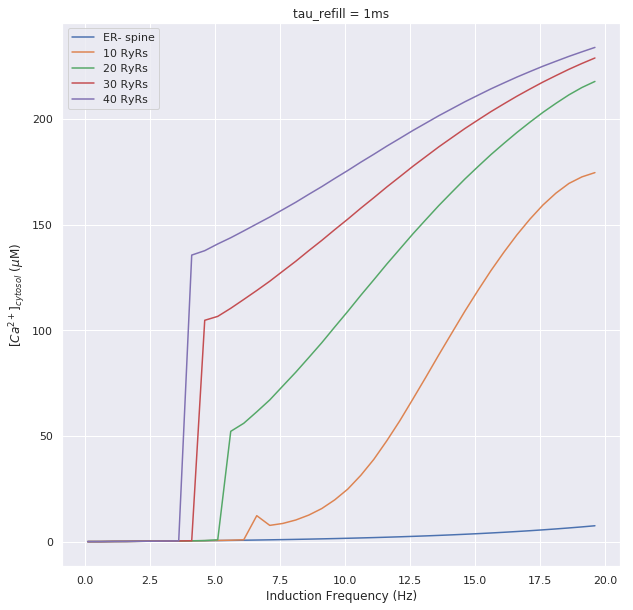

In [72]:
tmp0 = pd.read_csv('rdp25_3_0.csv')
tmp10 = pd.read_csv('rdp25_3_10_1.csv')
tmp20 = pd.read_csv('rdp25_3_20_1.csv')
tmp30 = pd.read_csv('rdp25_3_30_1.csv')
tmp40 = pd.read_csv('rdp25_3_40_1.csv')
# tmp50 = pd.read_csv('rdp25_0_50_1.csv')

fTrace = np.arange(0.1, 20.1, 0.5e0)
n_inputs = 25

temp0 = np.array(tmp0)
temp10 = np.array(tmp10)
temp20 = np.array(tmp20)
temp30 = np.array(tmp30)
temp40 = np.array(tmp40)
# temp50 = np.array(tmp50)

# ### for steady state calcium, condier the average of time response 
var0 = [np.average(temp0[int(n_inputs/fTrace[i] * 1000 - 1000):int(n_inputs/fTrace[i] * 1000 - 10),i]) for i in range(fTrace.shape[0])]   ## x1000  comes due to the choice of timestep, it can be changed
var10 = [np.average(temp10[int(n_inputs/fTrace[i] * 1000 - 1000):int(n_inputs/fTrace[i] * 1000 - 10),i]) for i in range(fTrace.shape[0])]
var20 = [np.average(temp20[int(n_inputs/fTrace[i] * 1000 - 1000):int(n_inputs/fTrace[i] * 1000 - 10),i]) for i in range(fTrace.shape[0])]
var30 = [np.average(temp30[int(n_inputs/fTrace[i] * 1000 - 1000):int(n_inputs/fTrace[i] * 1000 - 10),i]) for i in range(fTrace.shape[0])]
var40 = [np.average(temp40[int(n_inputs/fTrace[i] * 1000 - 1000):int(n_inputs/fTrace[i] * 1000 - 10),i]) for i in range(fTrace.shape[0])]
# var50 = [np.average(temp50[int(n_inputs/fTrace[i] * 1000 - 1000):int(n_inputs/fTrace[i] * 1000 - 10),i]) for i in range(fTrace.shape[0])]

print(temp0.shape)
print(temp10.shape)
print(temp20.shape)
print(temp30.shape)
print(temp40.shape)
# print(temp50.shape)

plt.figure(figsize = (10,10))
plt.title('tau_refill = 1ms')
plt.plot(fTrace, var0, label = 'ER- spine')
plt.plot(fTrace, var10, label = '10 RyRs')
plt.plot(fTrace, var20, label = '20 RyRs')
plt.plot(fTrace, var30, label = '30 RyRs')
plt.plot(fTrace, var40, label = '40 RyRs')
# plt.plot(fTrace, var50, label = '50 RyRs')
plt.xlabel('Induction Frequency (Hz)')
plt.ylabel('[$Ca^{2+}]_{cytosol}$ ($\mu$M)')
plt.legend()
plt.show()

RyRs to ER+ spine =  30
1


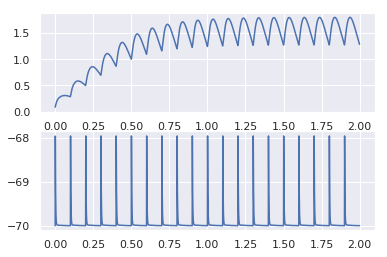

In [17]:
tau_refill = 1e0 #s
fTrace = np.arange(0.1, 20.1, 0.1)
t4 = np.arange(0., 2., 1e-3)
CaTimeCourse = np.zeros((t4.shape[0], fTrace.shape[0]))  ## With ER Stores (RyR mediated)
CaTimeCourse0 = np.zeros((t4.shape[0], fTrace.shape[0])) ## Without ER stores (not mediated by RyR)
itr = 0

g_NMDAR, n_RyR, n_inputs, input_pattern, f_input  = [65, 30, 25, 'rdp', 10]  #g_NMDAR is in pS
g_N = float(g_NMDAR) * 1e-12 
s = 1
Vmax_serca = 1
k_erleak = Vmax_serca * (ca_0**2)/((Kd_serca**2 + ca_0**2)*(ca_er_0 - ca_0))  ## /s
xinit = sol[-1,:]
print('RyRs to ER+ spine = ', n_RyR)
tpre = [i/float(f_input) for i in range(int(float(n_inputs)))] 
sol4 = odeint(spine_model, xinit, t4, atol=atol,rtol=rtol )   ## with ER stores
    ##############################################################
Vmax_serca = 0
k_erleak = 0
n_RyR = 0
sol40 = odeint(spine_model, xinit, t4, atol=atol,rtol=rtol)  ##without ER stores
#CaTimeCourse[:,freq] = sol4[:,-9]
#CaTimeCourse0[:,freq] = sol40[:,-9]
itr += 1
print(itr)
plt.subplot(2,1,1)
plt.plot(t4, sol40[:,-9])  
plt.subplot(2,1,2)
plt.plot(t4, sol4[:,-12])

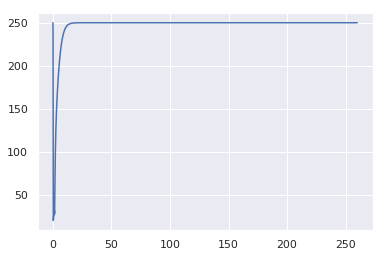

In [97]:
plt.plot(t4, sol4[:,-10])